# Import Libraries & Data

Apprentice Chef Analysis - Classification Modelling

Vi Nguyen

In [4]:
# importing all libraries
import pandas as pd                                   # data science essentials
import matplotlib.pyplot as plt                       # data visualization
import seaborn as sns                                 # enhanced data visualization
import numpy as np                                    # numpy for math
from sklearn.model_selection import train_test_split  # train-test split
from sklearn.linear_model import LogisticRegression   # logistic regression
import statsmodels.formula.api as smf                 # logistic regression
from sklearn.metrics import confusion_matrix          # confusion matrix
from sklearn.metrics import roc_auc_score             # auc score
from sklearn.neighbors import KNeighborsClassifier    # KNN for classification
from sklearn.neighbors import KNeighborsRegressor     # KNN for regression
from sklearn.preprocessing import StandardScaler      # standard scaler

# CART model packages
from sklearn.tree import DecisionTreeClassifier       # classification trees
from sklearn.tree import export_graphviz              # exports graphics
from six import StringIO                              # saves objects in memory
from IPython.display import Image                     # displays on frontend
import pydotplus                                      # interprets dot objects

#Packages for Classification Tree Modelling
from sklearn.model_selection import RandomizedSearchCV  # hyperparameter tuning
from sklearn.metrics import make_scorer                 # customizable scorer
from sklearn.ensemble import RandomForestClassifier     # random forest
from sklearn.ensemble import GradientBoostingClassifier # gbm

# setting pd print options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


# specify path and file name
file = 'Apprentice_Chef_Dataset.xlsx'


# reading the file
chef = pd.read_excel(io=file)

# #running the file
# chef.head(n=5)

# User Defined Functions

In [5]:
# text_split_feature UDF
#########################
def text_split_feature(col, df, sep=' ', new_col_name = 'NUM_OF_NAMES'):
    """
Splits values in a string Series (as part of a DataFrame) and sums the number
of resulting items. Automatically appends summed column to original DataFrame.

PARAMETERS
----------
col          : column to split
df           : DataFrame where column is located
sep          : string sequence to split by, default ' '
new_col_name : name of new column after summing split, default
               'number_of_names'
"""
    
    df[new_col_name] = 0
    
    
    for index, val in df.iterrows():
        df.loc[index, new_col_name] = len(df.loc[index, col].split(sep = ' '))

In [6]:
# optimal_neighbors UDF
########################################
def optimal_neighbors(x_data,
                      y_data,
                      standardize = True,
                      pct_test=0.25,
                      seed=219,
                      response_type='reg',
                      max_neighbors=20,
                      show_viz=True):
    """
Exhaustively compute training and testing results for KNN across
[1, max_neighbors]. Outputs the maximum test score and (by default) a
visualization of the results.
PARAMETERS
----------
x_data        : explanatory variable data
y_data        : response variable
standardize   : whether or not to standardize the X data, default True
pct_test      : test size for training and validation from (0,1), default 0.25
seed          : random seed to be used in algorithm, default 219
response_type : type of neighbors algorithm to use, default 'reg'
    Use 'reg' for regression (KNeighborsRegressor)
    Use 'class' for classification (KNeighborsClassifier)
max_neighbors : maximum number of neighbors in exhaustive search, default 20
show_viz      : display or surpress k-neigbors visualization, default True
"""    
    
    
    if standardize == True:
        # optionally standardizing X_data
        scaler             = StandardScaler()
        scaler.fit(x_data)
        x_scaled           = scaler.transform(x_data)
        x_scaled_df        = pd.DataFrame(x_scaled)
        x_data             = x_scaled_df



    # train-test split
    x_train, x_test, y_train, y_test = train_test_split(x_data,
                                                        y_data,
                                                        test_size = pct_test,
                                                        random_state = seed)


    # creating lists for training set accuracy and test set accuracy
    training_accuracy = []
    test_accuracy = []
    
    
    # setting neighbor range
    neighbors_settings = range(1, max_neighbors + 1)


    for n_neighbors in neighbors_settings:
        # building the model based on response variable type
        if response_type == 'reg':
            clf = KNeighborsRegressor(n_neighbors = n_neighbors)
            clf.fit(x_train, y_train)
            
        elif response_type == 'class':
            clf = KNeighborsClassifier(n_neighbors = n_neighbors)
            clf.fit(x_train, y_train)            
            
        else:
            print("Error: response_type must be 'reg' or 'class'")
        
        
        # recording the training set accuracy
        training_accuracy.append(clf.score(x_train, y_train))
    
        # recording the generalization accuracy
        test_accuracy.append(clf.score(x_test, y_test))


    # optionally displaying visualization
    if show_viz == True:
        # plotting the visualization
        fig, ax = plt.subplots(figsize=(12,8))
        plt.plot(neighbors_settings, training_accuracy, label = "training accuracy")
        plt.plot(neighbors_settings, test_accuracy, label = "test accuracy")
        plt.ylabel("Accuracy")
        plt.xlabel("n_neighbors")
        plt.legend()
        plt.show()
    
    
    # returning optimal number of neighbors
    print(f"The optimal number of neighbors is: {test_accuracy.index(max(test_accuracy))+1}")
    return test_accuracy.index(max(test_accuracy))+1

# Feature Engineering

In [7]:
###Cleaning and Splitting Emails into Necessary Domains

# STEP 1: splitting emails at the @ sign

# placeholder list
placeholder_lst = []

# looping each email address
for index, col in chef.iterrows():
    
    # splitting email domain at '@'
    split_email = chef.loc[index, 'EMAIL'].split(sep = '@')
    
    # appending placeholder_lst with the results
    placeholder_lst.append(split_email)
    

# convert to df 
email_df = pd.DataFrame(placeholder_lst)


# STEP 2:CONCATENATING DOMAINS AS A NEW COLUMN IN CHEF DF

# safety measure in case of multiple concatenations
chef = pd.read_excel(file)


# renaming column to concatenate
email_df.columns = ['0' , 'EMAIL_DOMAINS']


# concatenating email domains to chef
#adds the column to the dataset
chef = pd.concat([chef, email_df['EMAIL_DOMAINS']],
                   axis = 1)

# STEP 3: splitting emails at the '.'

# dot holder list (emails with no dots)
dotholder_lst = []

# looping over each email address
for index, col in chef.iterrows():
    
    # splitting email domain at '.'
    dot_email = chef.loc[index, 'EMAIL_DOMAINS'].split(sep = '.')
    
    # appending dotholder_lst with the results
    dotholder_lst.append(dot_email)
    

# converting cleanemail_df into a DataFrame 
cleanemail_df = pd.DataFrame(dotholder_lst)

# # displaying the results
# cleanemail_df

# STEP 4 :CONCATENATING CLEAN EMAIL DOMAINS AS A NEW COLUMN IN CHEF DF

# safety measure in case of multiple concatenations
chef = pd.read_excel(file)


# renaming column to concatenate
cleanemail_df.columns = ['CLEAN_MAIL' , '1']

#add the column to the dataset
chef = pd.concat([chef, cleanemail_df['CLEAN_MAIL']],
                   axis = 1)

In [11]:
# STEP 5: Aggregating personal and work emails

# email domain types
personal_email_domains = ['gmail','protonmail','yahoo']

work_email_domains  = ['amex','cocacola','jnj','merck',
                       'mcdonalds','nike','apple','dupont','ibm',
                       'ge','microsoft','chevron','travelers',
                       'exxon','unitedhealth','boeing','caterpillar',
                       'mmm','pg','verizon','walmart','disney',
                       'pfizer','visa','jpmorgan','unitedtech',
                       'cisco','goldmansacs','intel','homedepot']

junk_email_domains = ['msn','aol','hotmail','live','me', 'passport']

# placeholder list
holder_lst = []

# looping to group observations by domain type
for domain in chef['CLEAN_MAIL']:
    
        if domain in personal_email_domains:
            holder_lst.append('personal')
            
        elif domain in work_email_domains:
            holder_lst.append('work')
        
        elif domain in junk_email_domains:
            holder_lst.append('junk')
            
        else:
            print('Unknown')


# concatenating with original DataFrame
chef['DOMAIN_GROUP'] = pd.Series(holder_lst)

# # checking results
# chef['DOMAIN_GROUP'].value_counts()

In [12]:
## Taking out personal and work emails into columns 
# one hot encoding domain groups
ONE_HOT_DOMAIN = pd.get_dummies(chef['DOMAIN_GROUP'])

# dropping categorical variables after they've been encoded
chef = chef.drop('DOMAIN_GROUP', axis = 1)

# joining codings together
chef = chef.join([ONE_HOT_DOMAIN])

# saving new columns
new_columns = chef.columns

In [13]:
# calling text_split_feature to count names 
text_split_feature('NAME', chef, sep='')

In [16]:
#creating dummies for customers that were above the average
#L=[50%]
# dummy variables for vars with zeros.
chef['abv_TOTAL_MEALS_ORDERED']        = 0
chef['abv_UNIQUE_MEALS_PURCH']        = 0
for index, value in chef.iterrows():
    
    #total meals
    if chef.loc[index, 'TOTAL_MEALS_ORDERED'] > chef.loc[:,'TOTAL_MEALS_ORDERED'].median():
        chef.loc[index, 'abv_TOTAL_MEALS_ORDERED'] = 1
        
    #uniqe meals
    if chef.loc[index, 'UNIQUE_MEALS_PURCH'] > chef.loc[:,'UNIQUE_MEALS_PURCH'].median():
        chef.loc[index, 'abv_UNIQUE_MEALS_PURCH'] = 1  
        
#printing out variables        
# chef[['abv_TOTAL_MEALS_ORDERED','abv_UNIQUE_MEALS_PURCH']].head()

In [17]:
# creating a column for avg price meal
chef['AVG_PRICE_MEAL'] = chef['REVENUE']/chef['TOTAL_MEALS_ORDERED'].round(2)

#types of users 
chef['med_rater']     = 0

#itterating through the data to create user data
for index, val in chef.iterrows():
        
    #median rating for the price of meal if effected
    if chef.loc[index, 'MEDIAN_MEAL_RATING'] <= 3 and chef.loc[index, 'AVG_PRICE_MEAL'] > 34:
        chef.loc[index, 'med_rater'] = 1  

#checking variables just initiated 
# chef['med_rater'].head()

In [18]:
# saving feature-rich Chef dataset in excel
chef.to_excel('Chef_Ft_Classification.xlsx',index = False)

# Organizing Data

In [19]:
#dropping categorical variables/variables with strings

# declaring x-variables
chef_data = chef.drop(['CROSS_SELL_SUCCESS', 'NAME', 'EMAIL',
                       'FIRST_NAME', 'FAMILY_NAME', 'CLEAN_MAIL'], axis = 1)

In [21]:
#checking correlations of the dataset and engineered features 
chef_corr = chef.corr().round(2)

# chef_corr['CROSS_SELL_SUCCESS'].sort_values(ascending = False)

In [22]:
# declaring explanatory variables
chef_data = chef.drop(['CROSS_SELL_SUCCESS', 'NAME', 'EMAIL',
                       'FIRST_NAME', 'FAMILY_NAME', 'CLEAN_MAIL'], axis = 1)

# declaring response variable
chef_target = chef.loc[ : , 'CROSS_SELL_SUCCESS']

# train-test split with stratification
x_train, x_test, y_train, y_test = train_test_split(
            chef_data,
            chef_target,
            test_size    = 0.25,
            random_state = 219,
            stratify     = chef_target)


# merging training data for statsmodels
chef_train = pd.concat([x_train, y_train], axis = 1)

In [25]:
#adding a + to each variable
#locked to not print
#used to determine significant variables based on p-values below
for val in chef_data:
    print(f" {val} + ")

 REVENUE + 
 TOTAL_MEALS_ORDERED + 
 UNIQUE_MEALS_PURCH + 
 CONTACTS_W_CUSTOMER_SERVICE + 
 PRODUCT_CATEGORIES_VIEWED + 
 AVG_TIME_PER_SITE_VISIT + 
 MOBILE_NUMBER + 
 CANCELLATIONS_BEFORE_NOON + 
 CANCELLATIONS_AFTER_NOON + 
 TASTES_AND_PREFERENCES + 
 PC_LOGINS + 
 MOBILE_LOGINS + 
 WEEKLY_PLAN + 
 EARLY_DELIVERIES + 
 LATE_DELIVERIES + 
 PACKAGE_LOCKER + 
 REFRIGERATED_LOCKER + 
 AVG_PREP_VID_TIME + 
 LARGEST_ORDER_SIZE + 
 MASTER_CLASSES_ATTENDED + 
 MEDIAN_MEAL_RATING + 
 AVG_CLICKS_PER_VISIT + 
 TOTAL_PHOTOS_VIEWED + 
 junk + 
 personal + 
 work + 
 NUM_OF_NAMES + 
 abv_TOTAL_MEALS_ORDERED + 
 abv_UNIQUE_MEALS_PURCH + 
 AVG_PRICE_MEAL + 
 med_rater + 


In [23]:
##      LOG REGRESSION MODEL W/STATSMOD      ##
###############################################

#significant set 2
# instantiating a logistic regression model object
logistic_full = smf.logit(formula = """ CROSS_SELL_SUCCESS ~ 
                                         MOBILE_NUMBER + 
                                         CANCELLATIONS_BEFORE_NOON +  
                                         TASTES_AND_PREFERENCES + 
                                         PC_LOGINS + 
                                         EARLY_DELIVERIES + 
                                         REFRIGERATED_LOCKER + 
                                         work + 
                                         personal + 
                                         NUM_OF_NAMES +
                                         med_rater""",
                                        data = chef_train)


# fitting the model object
results_full = logistic_full.fit()


# checking the results SUMMARY
results_full.summary()

Optimization terminated successfully.
         Current function value: 0.540243
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:     CROSS_SELL_SUCCESS   No. Observations:                 1459
Model:                          Logit   Df Residuals:                     1448
Method:                           MLE   Df Model:                           10
Date:                Tue, 16 Mar 2021   Pseudo R-squ.:                  0.1397
Time:                        13:09:50   Log-Likelihood:                -788.22
converged:                       True   LL-Null:                       -916.19
Covariance Type:            nonrobust   LLR p-value:                 3.032e-49
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    -4.1156      0.674     -6.105      0.000      -5.437      -2.794
MOBILE_NUMBER                 0.9029      0.177      5.101      0.000       0.556       1.250
CANCELLATIONS_BEFORE_NOON     0.2804      0.046      6.033      0.000       0.189       0.371
TASTES_AND_PREFERENCES        0.4083      0.136      3.006      0.003       0.142       0.674
PC_LOGINS                     0.2317      0.107      2.159      0.031       0.021       0.442
EARLY_DELIVERIES              0.0571      0.028      2.065      0.039       0.003       0.111
REFRIGERATED_LOCKER           0.5204      0.208      2.498      0.013       0.112       0.929
work                          1.9067      0.172     11.093      0.000       1.570       2.244
personal                      1.3214      0.158      8.387      0.000       1.013       1.630
NUM_OF_NAMES                  0.5479      0.094      5.834      0.000       0.364       0.732
med_rater                    -0.3765      0.124     -3.030      0.002      -0.620      -0.133
=============================================================================================
"""

In [26]:
##  LOG REGRESSION MODEL W/STATSMOD & SET 3  ##
###############################################

#significant set 3
# instantiating a logistic regression model object
logistic_full = smf.logit(formula = """ CROSS_SELL_SUCCESS ~ 
                                         REVENUE +
                                         CONTACTS_W_CUSTOMER_SERVICE +
                                         MOBILE_NUMBER + 
                                         CANCELLATIONS_BEFORE_NOON +
                                         TASTES_AND_PREFERENCES + 
                                         PC_LOGINS +
                                         EARLY_DELIVERIES +
                                         REFRIGERATED_LOCKER +
                                         MASTER_CLASSES_ATTENDED +
                                         junk + 
                                         work + 
                                         NUM_OF_NAMES + 
                                         abv_TOTAL_MEALS_ORDERED +
                                         med_rater  """,
                                        data = chef_train)


# fitting the model object
results_full = logistic_full.fit()


# checking the results SUMMARY
results_full.summary()

Optimization terminated successfully.
         Current function value: 0.536436
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:     CROSS_SELL_SUCCESS   No. Observations:                 1459
Model:                          Logit   Df Residuals:                     1444
Method:                           MLE   Df Model:                           14
Date:                Tue, 16 Mar 2021   Pseudo R-squ.:                  0.1457
Time:                        13:11:27   Log-Likelihood:                -782.66
converged:                       True   LL-Null:                       -916.19
Covariance Type:            nonrobust   LLR p-value:                 8.381e-49
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                      -3.3112      0.696     -4.759      0.000      -4.675      -1.948
REVENUE                     -9.317e-05   6.91e-05     -1.349      0.177      -0.000    4.22e-05
CONTACTS_W_CUSTOMER_SERVICE     0.0701      0.028      2.486      0.013       0.015       0.125
MOBILE_NUMBER                   0.9189      0.178      5.155      0.000       0.570       1.268
CANCELLATIONS_BEFORE_NOON       0.2785      0.047      5.951      0.000       0.187       0.370
TASTES_AND_PREFERENCES          0.3975      0.137      2.910      0.004       0.130       0.665
PC_LOGINS                       0.2392      0.108      2.217      0.027       0.028       0.451
EARLY_DELIVERIES                0.0572      0.028      2.064      0.039       0.003       0.112
REFRIGERATED_LOCKER             0.5291      0.210      2.522      0.012       0.118       0.940
MASTER_CLASSES_ATTENDED         0.2369      0.109      2.169      0.030       0.023       0.451
junk                           -1.3536      0.160     -8.465      0.000      -1.667      -1.040
work                            0.5922      0.145      4.081      0.000       0.308       0.877
NUM_OF_NAMES                    0.5572      0.094      5.916      0.000       0.373       0.742
abv_TOTAL_MEALS_ORDERED         0.0772      0.180      0.429      0.668      -0.275       0.430
med_rater                      -0.3882      0.163     -2.378      0.017      -0.708      -0.068
===============================================================================================
"""

# LOGISTIC REGRESSION

In [33]:
# creating a variable dictionary to store candidate models

variable_dict = {

 # full model
 'logit_full'   : ['REVENUE','TOTAL_MEALS_ORDERED','UNIQUE_MEALS_PURCH',
                   'CONTACTS_W_CUSTOMER_SERVICE','PRODUCT_CATEGORIES_VIEWED',
                   'AVG_TIME_PER_SITE_VISIT','MOBILE_NUMBER','CANCELLATIONS_BEFORE_NOON',
                   'CANCELLATIONS_AFTER_NOON','TASTES_AND_PREFERENCES','PC_LOGINS',
                   'MOBILE_LOGINS','WEEKLY_PLAN','EARLY_DELIVERIES','LATE_DELIVERIES',
                   'PACKAGE_LOCKER','REFRIGERATED_LOCKER','AVG_PREP_VID_TIME',
                   'LARGEST_ORDER_SIZE','MASTER_CLASSES_ATTENDED','MEDIAN_MEAL_RATING',
                   'AVG_CLICKS_PER_VISIT','TOTAL_PHOTOS_VIEWED','junk','personal',
                   'work','NUM_OF_NAMES','abv_TOTAL_MEALS_ORDERED','abv_UNIQUE_MEALS_PURCH',
                   'AVG_PRICE_MEAL','med_rater'],
 
 # significant variables only (set 1)
 'logit_sig'    : ['MOBILE_NUMBER','CANCELLATIONS_BEFORE_NOON',
                   'TASTES_AND_PREFERENCES','NUM_OF_NAMES',
                   'PC_LOGINS','EARLY_DELIVERIES',
                   'work','personal','REFRIGERATED_LOCKER',
                   'abv_TOTAL_MEALS_ORDERED'],

 # significant variables only (set 2)
 'logit_sig_2'  : ['MOBILE_NUMBER', 'CANCELLATIONS_BEFORE_NOON', 
                  'TASTES_AND_PREFERENCES', 'PC_LOGINS', 'EARLY_DELIVERIES',
                  'REFRIGERATED_LOCKER', 'junk', 'work', 
                  'NUM_OF_NAMES'],
 
 # significant variables only (set 3)
 'logit_sig_3'  : ['REVENUE','CONTACTS_W_CUSTOMER_SERVICE','MOBILE_NUMBER',
                   'CANCELLATIONS_BEFORE_NOON','TASTES_AND_PREFERENCES',
                   'PC_LOGINS','EARLY_DELIVERIES','REFRIGERATED_LOCKER',
                   'MASTER_CLASSES_ATTENDED','junk','work','NUM_OF_NAMES',
                   'abv_TOTAL_MEALS_ORDERED','med_rater' ]

    
}

In [34]:
#declaring variables for the log reg model
chef_data   =  chef.loc[ : , variable_dict['logit_full']]
chef_target =  chef.loc[ : , 'CROSS_SELL_SUCCESS']

# train/test split
x_train, x_test, y_train, y_test = train_test_split(
                                chef_data,
                                chef_target,
                                random_state = 219,
                                test_size    = 0.25,
                                stratify     = chef_target)

## Logistic Regression Tuned 

In [ ]:
# PARAMETER TUNING for LOG REGRESSION #
########################################

# declaring a hyperparameter space
C_space          = pd.np.arange(0.1, 5.0, 0.1)
warm_start_space = [True, False]
solver_space     = ['newton-cg', 'sag', 'lbfgs']


# creating a hyperparameter grid
param_grid = {'C'          : C_space,
              'warm_start' : warm_start_space,
              'solver'     : solver_space}


#the model object without hyperparameters
lr_tuned = LogisticRegression(random_state = 219,
                              max_iter     = 1000)

# GridSearchCV object paramters
lr_tuned_cv = RandomizedSearchCV(estimator           = lr_tuned,  
                                 param_distributions = param_grid, 
                                 cv                  = 3,         
                                 n_iter              = 1000,        
                                 random_state        = 219,       
                                 scoring = make_scorer(
                                           roc_auc_score,
                                           needs_threshold = False)) # scoring criteria (AUC)

# FITTING to the FULL DATASET (due to cross-validation)
lr_tuned_cv.fit(chef_data, chef_target)

# printing the optimal parameters and best score
print("Tuned Parameters  :", lr_tuned_cv.best_params_)
print("Tuned CV AUC      :", lr_tuned_cv.best_score_.round(4))

In [35]:
# INSTANTIATING a logistic regression model with tuned parameters
#parameters come from above when tuning the model below

lr_tuned = LogisticRegression(C            = 3.2,
                              random_state = 219, 
                              solver       = 'newton-cg', 
                              warm_start   = True)

#fitting the data
lr_tuned_fit = lr_tuned.fit(x_train, y_train)

# PREDICTING based on the testing set
lr_tuned_pred = lr_tuned.predict(x_test)


# SCORING the results
print('LR Tuned Training ACCURACY:', lr_tuned.score(x_train, y_train).round(4))
print('LR Tuned Testing  ACCURACY:', lr_tuned.score(x_test, y_test).round(4))
print('LR Tuned AUC Score        :', roc_auc_score(y_true  = y_test,
                                          y_score = lr_tuned_pred).round(4))


# saving scoring data for future use
lr_tuned_train_score = lr_tuned.score(x_train, y_train).round(4) # accuracy
lr_tuned_test_score  = lr_tuned.score(x_test, y_test).round(4)   # accuracy


# saving the AUC score
lr_tuned_auc         = roc_auc_score(y_true  = y_test,
                                     y_score = lr_tuned_pred).round(4) # auc

LR Tuned Training ACCURACY: 0.7464
LR Tuned Testing  ACCURACY: 0.7515
LR Tuned AUC Score        : 0.6596


In [36]:
# unpacking the confusion matrix
lrtuned_tn, \
lrtuned_fp, \
lrtuned_fn, \
lrtuned_tp = confusion_matrix(y_true = y_test, y_pred = lr_tuned_pred).ravel()

# Classification Trees

## Full Tree

In [37]:
#Initiating the data to be used on the full tree
chef_data   =  chef.loc[ : , variable_dict['logit_full']]
chef_target =  chef.loc[ : , 'CROSS_SELL_SUCCESS']

# train/test split
x_train, x_test, y_train, y_test = train_test_split(
                                chef_data,
                                chef_target,
                                random_state = 219,
                                test_size    = 0.25,
                                stratify     = chef_target)

In [38]:
# Initiating a Full Tree Model
full_tree = DecisionTreeClassifier()


# FITTING the training data
full_tree_fit = full_tree.fit(x_train, y_train)


# PREDICTING on new data
full_tree_pred = full_tree_fit.predict(x_test)


# SCORING the model
print('Full Tree Training ACCURACY:', full_tree_fit.score(x_train,
                                                    y_train).round(4))

print('Full Tree Testing ACCURACY :', full_tree_fit.score(x_test,
                                                    y_test).round(4))

print('Full Tree AUC Score:', roc_auc_score(y_true  = y_test,
                                            y_score = full_tree_pred).round(4))

# save scores
full_tree_train_score = full_tree_fit.score(x_train, y_train).round(4) # accuracy
full_tree_test_score  = full_tree_fit.score(x_test, y_test).round(4)   # accuracy

# saving AUC
full_tree_auc_score   = roc_auc_score(y_true  = y_test,
                                      y_score = full_tree_pred).round(4) # auc

Full Tree Training ACCURACY: 1.0
Full Tree Testing ACCURACY : 0.6509
Full Tree AUC Score: 0.6127


In [39]:
# unpacking the confusion matrix
full_tree_tn, \
full_tree_fp, \
full_tree_fn, \
full_tree_tp = confusion_matrix(y_true = y_test, y_pred = full_tree_pred).ravel()

## Pruned Tree 

In [40]:
#Initiating data in the pruned tree model
chef_data   =  chef.loc[ : , variable_dict['logit_full']]
chef_target =  chef.loc[ : , 'CROSS_SELL_SUCCESS']

# train/test split
x_train, x_test, y_train, y_test = train_test_split(
                    chef_data,
                    chef_target,
                    random_state = 219,
                    test_size    = 0.25,
                    stratify     = chef_target)

In [41]:
# Initiating a Pruned Tree Model
pruned_tree = DecisionTreeClassifier(max_depth        = 3,
                                     min_samples_leaf = 25,
                                     random_state     = 219)

# FITTING the training data
pruned_tree_fit  = pruned_tree.fit(chef_data, chef_target)


# PREDICTING on new data
pruned_tree_pred = pruned_tree_fit.predict(x_test)


# SCORING the model
print('Training ACCURACY:', pruned_tree_fit.score(x_train, y_train).round(4))
print('Testing  ACCURACY:', pruned_tree_fit.score(x_test, y_test).round(4))
print('AUC Score        :', roc_auc_score(y_true  = y_test,
                                          y_score = pruned_tree_pred).round(4))


# saving scoring data for future use
pruned_tree_train_score = pruned_tree_fit.score(x_train, y_train).round(4) # accuracy
pruned_tree_test_score  = pruned_tree_fit.score(x_test, y_test).round(4)   # accuracy


# saving auc score
pruned_tree_auc_score   = roc_auc_score(y_true  = y_test,
                                        y_score = pruned_tree_pred).round(4) # auc

Training ACCURACY: 0.7402
Testing  ACCURACY: 0.7762
AUC Score        : 0.732


In [42]:
#creating variables from confusion matrix
pruned_tree_tn, \
pruned_tree_fp, \
pruned_tree_fn, \
pruned_tree_tp = confusion_matrix(y_true = y_test, y_pred = pruned_tree_pred).ravel()

## Tuned Tree 

In [43]:
#Initiating data in the tuned classification tree model
chef_data   =  chef.loc[ : , variable_dict['logit_sig_2']]
chef_target =  chef.loc[ : , 'CROSS_SELL_SUCCESS']

# train/test split
x_train, x_test, y_train, y_test = train_test_split(
                                chef_data,
                                chef_target,
                                random_state = 219,
                                test_size    = 0.25,
                                stratify     = chef_target)

In [55]:
##        Tree Parameter Tuning      ##
#######################################
criterion_space = ['gini', 'entropy']
splitter_space  = ['best', 'random']
depth_space     = pd.np.arange(1, 25, 1)
leaf_space      = pd.np.arange(1, 100, 1)


# creating a hyperparameter grid
param_grid = {'criterion'        : criterion_space,
              'splitter'         : splitter_space,
              'max_depth'        : depth_space,
              'min_samples_leaf' : leaf_space}


# INSTANTIATING the model object without hyperparameters
tuned_tree = DecisionTreeClassifier(random_state = 219)
# RandomizedSearchCV object
tuned_tree_cv = RandomizedSearchCV(estimator             = tuned_tree,
                                   param_distributions   = param_grid,
                                   cv                    = 3,
                                   n_iter                = 1000, # changed for the sake of time
                                   random_state          = 219,
                                   scoring = make_scorer(roc_auc_score,
                                             needs_threshold = False))


# FITTING to the FULL DATASET (due to cross-validation)
tuned_tree_cv.fit(chef_data, chef_target)


# PREDICT step is not needed


# printing the optimal parameters and best score
print("Tuned Parameters  :", tuned_tree_cv.best_params_)
print("Tuned Training AUC:", tuned_tree_cv.best_score_.round(4))


<ipython-input-55-4a735b0e6a36>:6: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  depth_space     = pd.np.arange(1, 25, 1)
<ipython-input-55-4a735b0e6a36>:7: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  leaf_space      = pd.np.arange(1, 100, 1)


Tuned Parameters  : {'splitter': 'best', 'min_samples_leaf': 16, 'max_depth': 3, 'criterion': 'gini'}
Tuned Training AUC: 0.7032


In [44]:
# building classification model based on hyperparameter tuning results
#tuning results came from above where the hyperparameter tuning code was used

# classification tree model with tuned values from above
tree_tuned = DecisionTreeClassifier(criterion        = 'gini',
                                    max_depth        = 3,
                                    max_features     = None,
                                    min_samples_leaf = 16,
                                    random_state     = 219,
                                    splitter         = 'best')

# Fitting training data
tree_tuned_fit  = tree_tuned.fit(chef_data, chef_target)

# PREDICTING based on the testing set
tree_tuned_pred = tree_tuned.predict(x_test)

# SCORING the results
print('Tuned Tree Training ACCURACY:', tree_tuned.score(x_train, y_train).round(4))
print('Tuned Tree Testing ACCURACY :', tree_tuned.score(x_test, y_test).round(4))
print('Tuned Tree AUC Score        :', roc_auc_score(y_true  = y_test,
                                                     y_score = tree_tuned_pred).round(4))


# saving scoring data for future use
tree_tuned_train_score = tree_tuned.score(x_train, y_train).round(4) # accuracy
tree_tuned_test_score  = tree_tuned.score(x_test, y_test).round(4)   # accuracy


# saving the AUC score
tree_tuned_auc         = roc_auc_score(y_true  = y_test,
                                     y_score = tree_tuned_pred).round(4) # auc


Tuned Tree Training ACCURACY: 0.7402
Tuned Tree Testing ACCURACY : 0.7762
Tuned Tree AUC Score        : 0.732


In [45]:
# unpacking the confusion matrix
tuned_tree_tn, \
tuned_tree_fp, \
tuned_tree_fn, \
tuned_tree_tp = confusion_matrix(y_true = y_test, y_pred = tree_tuned_pred).ravel()

## Random Forest 

In [46]:
#declaring the correct variables to be used in random forest
chef_data   =  chef.loc[ : , variable_dict['logit_sig_2']]
chef_target =  chef.loc[ : , 'CROSS_SELL_SUCCESS']

# train/test split
x_train, x_test, y_train, y_test = train_test_split(
                                chef_data,
                                chef_target,
                                random_state = 219,
                                test_size    = 0.25,
                                stratify     = chef_target)

In [37]:
# INSTANTIATING a random forest model with default values
rf_default = RandomForestClassifier(n_estimators     = 100,
                                    criterion        = 'gini',
                                    max_depth        = None,
                                    min_samples_leaf = 2,
                                    bootstrap        = True,
                                    warm_start       = False,
                                    random_state     = 219)
# Fit the training data
rf_default_fit = rf_default.fit(x_train, y_train)


# Predicting on testing set
rf_default_fit_pred = rf_default_fit.predict(x_test)


# declaring hyperparameter space
estimator_space  = pd.np.arange(100, 1100, 250)
leaf_space       = pd.np.arange(1, 31, 10)
criterion_space  = ['gini', 'entropy']
bootstrap_space  = [True, False]
warm_start_space = [True, False]


# create hyperparameter grid
param_grid = {'n_estimators'     : estimator_space,
              'min_samples_leaf' : leaf_space,
              'criterion'        : criterion_space,
              'bootstrap'        : bootstrap_space,
              'warm_start'       : warm_start_space}


# INSTANTIATING the model object without hyperparameters
forest_grid = RandomForestClassifier(random_state = 219)


# GridSearchCV object
forest_cv = RandomizedSearchCV(estimator           = forest_grid,
                               param_distributions = param_grid,
                               cv                  = 3,
                               n_iter              = 500,
                               scoring             = make_scorer(roc_auc_score,
                               needs_threshold     = False))


# FITTING to the FULL DATASET (due to cross-validation)
forest_cv.fit(chef_data, chef_target)

# printing the optimal parameters and best score
print("Tuned Parameters  :", forest_cv.best_params_)
print("Tuned Training AUC:", forest_cv.best_score_.round(4))

<ipython-input-37-6d6f2cfa3e93>:18: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  estimator_space  = pd.np.arange(100, 1100, 250)
<ipython-input-37-6d6f2cfa3e93>:19: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  leaf_space       = pd.np.arange(1, 31, 10)
C:\Users\Nguye\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:278: UserWarning: The total space of parameters 96 is smaller than n_iter=500. Running 96 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Tuned Parameters  : {'warm_start': True, 'n_estimators': 600, 'min_samples_leaf': 21, 'criterion': 'gini', 'bootstrap': False}
Tuned Training AUC: 0.6815


In [47]:
# building a model based on hyperparameter tuning results

# copying over the tune parameters into the model 
# avoids running another RandomizedSearchCV
forest_tuned = RandomForestClassifier(n_estimators     = 600,
                                      criterion        = 'gini',
                                      max_depth        = None,
                                      min_samples_leaf = 21,
                                      bootstrap        = False,
                                      warm_start       = True,
                                      random_state     = 219)

# Fit model object
forest_tuned_fit = forest_tuned.fit(chef_data, chef_target)

# Predicting based on the testing set
forest_tuned_pred = forest_tuned_fit.predict(x_test)

# Score the results
print('Forest Tuned Training ACCURACY:', forest_tuned.score(x_train, y_train).round(4))
print('Forest Tuned Testing  ACCURACY:', forest_tuned.score(x_test, y_test).round(4))
print('Forest Tuned AUC Score        :', roc_auc_score(y_true  = y_test,
                                                       y_score = forest_tuned_pred).round(4))

# saving score data for future use
forest_tuned_train_score = forest_tuned.score(x_train, y_train).round(4) # accuracy
forest_tuned_test_score  = forest_tuned.score(x_test, y_test).round(4)   # accuracy

# saving the AUC score
forest_tuned_auc = roc_auc_score(y_true  = y_test,
                                 y_score = forest_tuned_pred).round(4) # auc

Forest Tuned Training ACCURACY: 0.7656
Forest Tuned Testing  ACCURACY: 0.7885
Forest Tuned AUC Score        : 0.719


In [48]:
#Initiating confusing matrix values
tuned_rf_tn, \
tuned_rf_fp, \
tuned_rf_fn, \
tuned_rf_tp = confusion_matrix(y_true = y_test, y_pred = forest_tuned_pred).ravel()

# KNN Classification

In [49]:
#initiating dataset to use in classification
chef_data   =  chef.loc[ : , variable_dict['logit_sig_2']]
chef_target =  chef.loc[ : , 'CROSS_SELL_SUCCESS']

# train/test split
x_train, x_test, y_train, y_test = train_test_split(
                                chef_data,
                                chef_target,
                                random_state = 219,
                                test_size    = 0.25,
                                stratify     = chef_target)

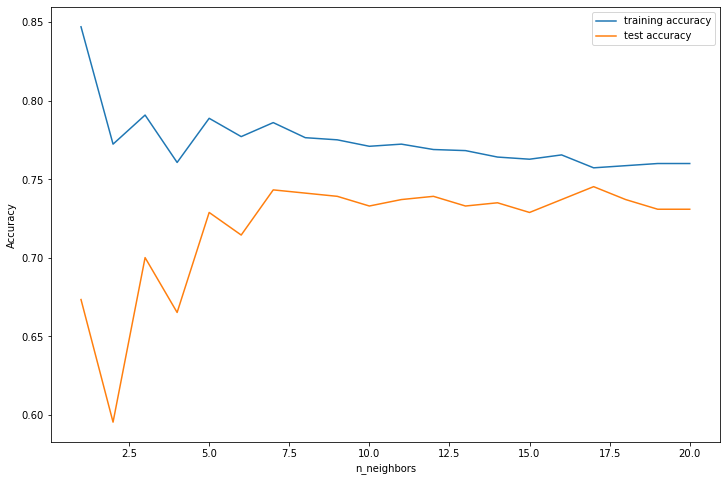

The optimal number of neighbors is: 17


In [50]:
# determining the optimal number of neighbors
opt_neighbors = optimal_neighbors(x_data        = chef_data,
                                  y_data        = chef_target,
                                  response_type = 'class')

In [51]:
#Scaling the data through the code below
scaler = StandardScaler()

scaler.fit(chef_data)

x_scaled     = scaler.transform(chef_data)

# converting scaled data to a DF
x_scaled_df  = pd.DataFrame(x_scaled) 


# train-test split with newly scaled data
x_train_scaled, x_test_scaled, y_train_scaled, y_test_scaled = train_test_split(
            x_scaled_df,
            chef_target,
            random_state = 219,
            test_size = 0.25,
            stratify = chef_target)

# KNN classification model with optimal neighbors
knn_opt = KNeighborsClassifier(n_neighbors = opt_neighbors)

knn_fit = knn_opt.fit(x_train_scaled, y_train_scaled)

knn_pred = knn_fit.predict(x_test_scaled)

# Print Scores
print('KNN Training ACCURACY:', knn_fit.score(x_train_scaled, y_train_scaled).round(4))
print('KNN Testing  ACCURACY:', knn_fit.score(x_test_scaled, y_test_scaled).round(4))
print('KNN AUC Score        :', roc_auc_score(y_true  = y_test,
                                              y_score = knn_pred).round(4))

# saving scores
knn_train_score = knn_fit.score(x_train_scaled, y_train_scaled).round(4)
knn_test_score  = knn_fit.score(x_test_scaled, y_test_scaled).round(4)

# saving AUC score
knn_auc_score   = roc_auc_score(y_true  = y_test,
                                          y_score = knn_pred).round(4)

KNN Training ACCURACY: 0.7546
KNN Testing  ACCURACY: 0.7392
KNN AUC Score        : 0.6455


In [52]:
# unpacking the confusion matrix
knn_tree_tn, \
knn_tree_fp, \
knn_tree_fn, \
knn_tree_tp = confusion_matrix(y_true = y_test, y_pred = knn_pred).ravel()

In [53]:
# creating a dictionary for model results
model_performance = {

#Model Names 
    'Model Name'    : ['Logistic Tuned', 'Full Tree', 'Pruned Tree', 'Scaled KNN',
                      'Tuned Tree', 'Tuned Forest'],
#AUC Score values           
    'AUC Score' : [lr_tuned_auc , full_tree_auc_score, pruned_tree_auc_score, 
                   knn_auc_score, tree_tuned_auc, forest_tuned_auc],
    
#training accuracy values   
    'Training Accuracy' : [lr_tuned_train_score, full_tree_train_score,
                           pruned_tree_train_score, knn_train_score,
                          tree_tuned_train_score, forest_tuned_train_score],
#testing accuracy values 
    'Testing Accuracy'  : [lr_tuned_test_score, full_tree_test_score,
                           pruned_tree_test_score, knn_test_score,
                          tree_tuned_test_score, forest_tuned_test_score],
#confusion matrix values
    'Confusion Matrix'  : [(lrtuned_tn, lrtuned_fp, lrtuned_fn, lrtuned_tp),
                           (full_tree_tn, full_tree_fp, full_tree_fn, full_tree_tp),
                           (pruned_tree_tn, pruned_tree_fp, pruned_tree_fn, pruned_tree_tp),
                           (knn_tree_tn, knn_tree_fp, knn_tree_fn, knn_tree_tp),
                           (tuned_tree_tn, tuned_tree_fp, tuned_tree_fn, tuned_tree_tp),
                           (tuned_rf_tn,tuned_rf_fp,tuned_rf_fn,tuned_rf_tp)]}


# converting model_performance into a DataFrame
model_performance = pd.DataFrame(model_performance)


# sending model results to Excel
model_performance.to_excel('./chef_modelperformance_Vi.xlsx',
                           index = False)

In [55]:
#printout for the model chosen

print("""Therefore, my best model based on the AUC score is the Pruned Tree Model.\t
Seen from the values below.""")


model_performance.sort_values(by = 'AUC Score', ascending = False)



Therefore, my best model based on the AUC score is the Pruned Tree Model.	
Seen from the values below.


,Model Name,AUC Score,Training Accuracy,Testing Accuracy,Confusion Matrix
2,Pruned Tree,0.7320,0.7402,0.7762,"(95, 61, 48, 283)"
4,Tuned Tree,0.7320,0.7402,0.7762,"(95, 61, 48, 283)"
5,Tuned Forest,0.7190,0.7656,0.7885,"(82, 74, 29, 302)"
0,Logistic Tuned,0.6596,0.7464,0.7515,"(63, 93, 28, 303)"
3,Scaled KNN,0.6455,0.7546,0.7392,"(60, 96, 31, 300)"
1,Full Tree,0.6127,1.0000,0.6509,"(79, 77, 93, 238)"
